# TSMixer: Tuning

### Setup

In [1]:
from src.load_data import *
from src.realtime_utils import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [2]:
from darts.models import TSMixerModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.


### Configuration

In [4]:
NAME = 'tsmixer'

In [5]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    likelihood=NegativeBinomialLikelihood(),
    pl_trainer_kwargs={
       "enable_progress_bar" : True,
       "enable_model_summary" : False,
       "accelerator" : "cpu",
       "callbacks" : [RichProgressBar(leave=True)]
    }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

In [14]:
sweep_configuration = {
    "name": f"sari-{NAME}",
    "method": "grid",
    "metric": {"goal": "minimize", "name": "WIS"},
    "parameters": {
        "model" : {"values" : [NAME]},
        "use_static_covariates" :  {"values" : [False]},
        "use_covariates" :  {"values" : [True, False]},
        "use_features" :  {"values" : [False]},
        "use_encoders" :  {"values" : [True]},
        "sample_weight" : {"values" : ["linear", "no-covid"]},
        "input_chunk_length" : {"values" : [8]},
        "hidden_size" : {"values" : [32, 64]},
        "ff_size" : {"values" : [32, 64]},
        "num_blocks" : {"values" : [4, 6]},
        "dropout" : {"values" : [0.2]}, # 0.05, 0.1, 0.2, 0.3, 0.5
        "norm_type"  : {"values" : ['TimeBatchNorm2d']}, # 'LayerNorm', 
        "batch_size" : {"values" : [32]},
        "n_epochs" : {"values" : [500, 1000]},
        "normalize_before" : {"values" : [False]},
        "activation" : {"values" : ["ReLU"]}, # "ReLU", "GELU", "LeakyReLU", "ELU"
        "optimizer" : {"values": ["AdamW"]}, # SGD, "Adam", 
        "optimizer_kwargs" : {
            "parameters": {
                "lr" : {"values" : [0.0005, 0.001, 0.005]},
                "weight_decay" : {"values" : [0, 0.001, 0.0001]}
            }
        }
    }
}

### Load data

In [7]:
targets, covariates = load_realtime_training_data()

In [8]:
targets_train, targets_validation = train_validation_split(targets, 2022)

<Axes: xlabel='date'>

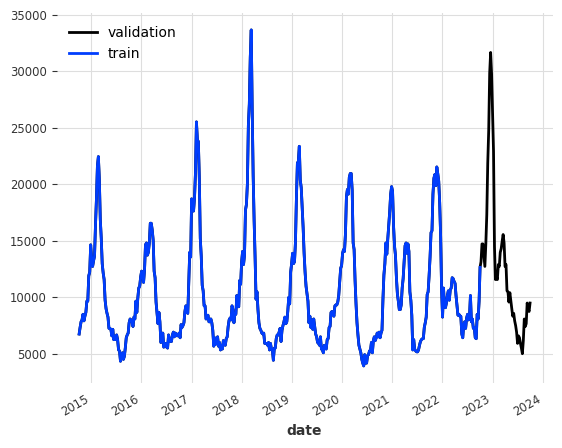

In [9]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

### Expanding window with multiple runs

In [10]:
VALIDATION_YEARS = [2022]

In [11]:
RANDOM_SEEDS = [1, 2, 3]

In [12]:
custom_weights = exclude_covid_weights(targets)

In [15]:
# Expanding window
def objective(config):
    optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    use_features = config.use_features
    use_encoders = config.use_encoders
    sample_weight = config.sample_weight
    
    model = TSMixerModel(
        input_chunk_length=config.input_chunk_length,
        hidden_size=config.hidden_size,
        ff_size=config.ff_size,
        num_blocks=config.num_blocks,
        dropout=config.dropout,
        norm_type=config.norm_type,
        batch_size=config.batch_size,
        n_epochs=config.n_epochs,
        normalize_before=config.normalize_before,
        activation=config.activation,
        optimizer_cls=optimizer,
        optimizer_kwargs={**config.optimizer_kwargs},
        use_static_covariates=config.use_static_covariates,
        add_encoders=ENCODERS if use_encoders else None,
        
        **SHARED_ARGS
    )
    
    
    scores = []
    for validation_year in VALIDATION_YEARS:
        targets_train, targets_validation = train_validation_split(targets, validation_year)
        scores_year = []
        for seed in RANDOM_SEEDS:
            model.reset_model()
            model.model_params['random_state'] = seed
            
            score = compute_validation_score(model, targets_train, targets_validation, covariates if use_covariates else None, 
                                             HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS,
                                             sample_weight=custom_weights if sample_weight == "no-covid" else sample_weight)
            scores.append(score)
            scores_year.append(score)
            wandb.log({f'WIS_{validation_year}_{seed}' : score})
            
            # if score > 600:
            #     run.finish()
            #     return
             
        wandb.log({f'WIS_{validation_year}' : np.mean(scores_year)})
        wandb.log({f'WIS_std_{validation_year}' : np.std(scores_year)})
        

            
    avg_score = np.mean(scores) # average across all runs
    std = np.std(scores)
    
    wandb.log({'WIS_std' : std})

    return avg_score

### Run tuning

In [16]:
def main():
    run = wandb.init()
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [17]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="sari-tsmixer")

Create sweep with ID: cuupnrb7
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/sari-tsmixer/sweeps/cuupnrb7


In [ ]:
wandb.agent(sweep_id, function=main)

Epoch 6/499 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━ 11/13 0:00:00 • 0:00:01 33.11it/s train_loss: 17.577 

In [ ]:
# wandb.agent(sweep_id='7gxhk8q9', function=main, count=1000, project="realtime-tsmixer-expanding-window")